# 51 Peg b

## Packages

In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u

In [2]:
!pip install --quiet astrobase pymc3_ext corner exoplanet radvel

In [3]:
%matplotlib inline

In [4]:
import exoplanet as xo
import astrobase.periodbase
import pymc3_ext as pmx
import corner
import radvel
import pymc3 as pm
import arviz as az
import aesara_theano_fallback.tensor as tt

/usr/local/lib/python3.7/dist-packages/radvel/gp.py:33: ImportWarning: celerite not installed. GP kernals using celerite will not work. Try installing celerite using 'pip install celerite'
  Try installing celerite using 'pip install celerite'", ImportWarning)


## Download the data

In [33]:
url = "https://exoplanetarchive.ipac.caltech.edu/data/ExoData/0113/0113357/data/UID_0113357_RVC_001.tbl"
r = requests.get(url)

if r.status_code != requests.codes.ok:
    r.raise_for_status()

data = np.array([l.split() for l in r.text.splitlines() if not l.startswith("\\") and not l.startswith("|")], dtype = float,)

t, rv, rv_err = data.T
t -= np.mean(t)

In [34]:
%matplotlib inline

## Lomb-Scargle

In [35]:
zgls = astrobase.periodbase.zgls.pgen_lsp(t, rv, rv_err, 
                                          magsarefluxes = False,
                                          startp = 1, 
                                          endp = 1000, 
                                          stepsize = 1/(5 * (t.max() - t.min())), 
                                          autofreq = False, 
                                          nbestpeaks = 1, 
                                          periodepsilon = 0.1, 
                                          sigclip = None, 
                                          nworkers = 4, 
                                          workchunksize = False, 
                                          verbose = True)

In [36]:
period = zgls['bestperiod']
print(f'P = {period} days')

power, periods = zgls['lspvals'], zgls['periods']

P = 4.230361708387039 days


In [37]:
phase = lambda t, period: np.remainder(t, period)/period

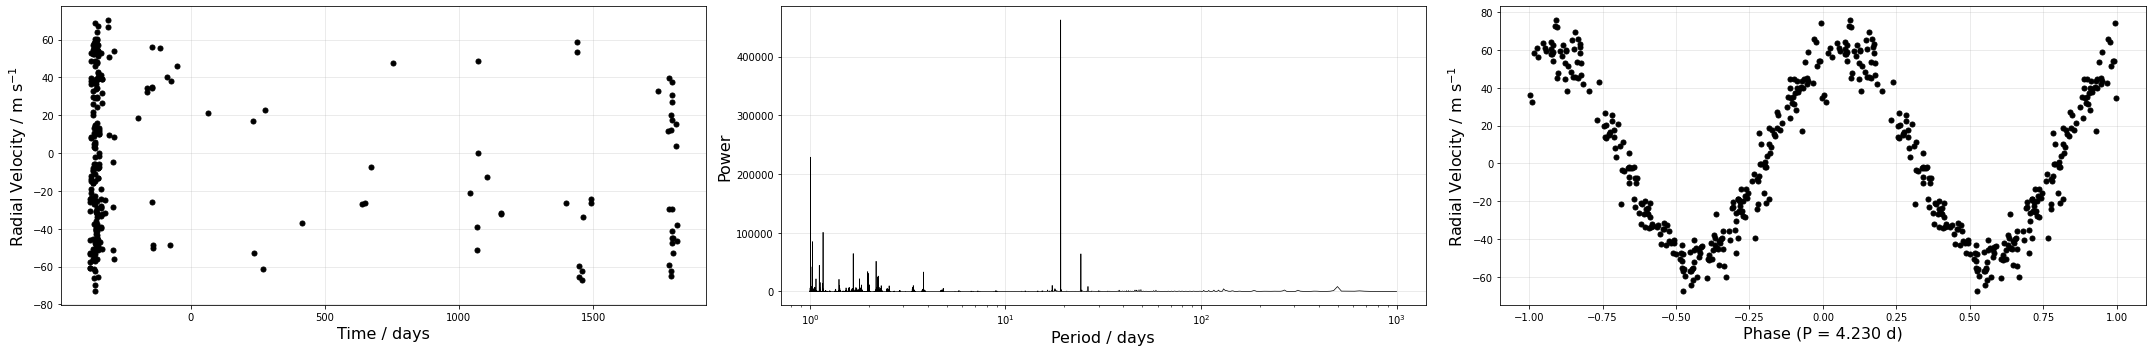

In [38]:
fig, [ax1, ax2, ax3] = plt.subplots(figsize = (30, 5), nrows = 1, ncols = 3)

ax1.grid(alpha = 0.3)
ax1.set_xlabel('Time / days', fontsize = 16)
ax1.set_ylabel(r'Radial Velocity / m s$^{-1}$', fontsize = 16)
ax1.errorbar(t, rv, fmt = 'ok')

ax2.grid(alpha = 0.3)
ax2.set(xscale = 'log')
ax2.set_xlabel('Period / days', fontsize = 16)
ax2.set_ylabel(r'Power', fontsize = 16)
ax2.plot(periods, 1/power, lw = 0.7, color = 'k')

ax3.grid(alpha = 0.3)
ax3.set_xlabel('Phase (P = %.3f d)'%(period), fontsize = 16)
ax3.set_ylabel(r'Radial Velocity / m s$^{-1}$', fontsize = 16)
ax3.errorbar(np.concatenate([phase(t, period), phase(t, period)-1]), 
             np.concatenate([rv - rv.mean(), rv - rv.mean()]), fmt = 'ok')

plt.tight_layout()

plt.savefig('51Pegb_RV_periodogram_phased.pdf')

## HMC/PyMC3 RV Modelling

In [39]:
t0 = t[np.argmax(rv)]
print(t0)

-308.43310652766377


In [40]:
x, y, yerr = t, rv, rv_err

In [41]:
print(f'astrobase: {period} days')
periods = float('%.7f'%(period))
Ks = np.abs(xo.estimate_semi_amplitude(period, x, y, yerr, t0s = t0))
print(Ks, "m/s")

astrobase: 4.230361708387039 days
[10.16462731] m/s


In [42]:
# Fine grid for plotting purposes
t = np.linspace(x.min() - 5, x.max() + 5, 1000)

In [43]:
with pm.Model() as model:

  # Priors
  logK = pm.Uniform('logK', lower = 0, upper = np.log(200), testval = np.log(0.5 * (np.max(y) - np.min(y))))
  logP = pm.Uniform('logP', lower = 0, upper = np.log(100), testval=np.log(periods))
  phi = pm.Uniform('phi', lower = 0, upper = 2 * np.pi, testval = 0.1)

  # Eccentricity
  # h := sqrt(e) * sin(w)
  # k := sqrt(e) * cos(w)
  hk = pmx.UnitDisk('hk', testval = np.array([0.5, 0.5]))
  e = pm.Deterministic('e', hk[0] ** 2 + hk[1] ** 2)
  w = pm.Deterministic('w', tt.arctan2(hk[1], hk[0]))

  rv0 = pm.Normal('rv0', mu = 0, sd = 10, testval = 0)
  rvtrend = pm.Normal('rvtrend', mu = 0, sd = 10, testval = 0)

  # Deterministic transformations
  n = 2 * np.pi * tt.exp(-logP)
  P = pm.Deterministic('P', tt.exp(logP))
  K = pm.Deterministic('K', tt.exp(logK))

  cosw = tt.cos(w)
  sinw = tt.sin(w)
  
  # RV model
  bkg = pm.Deterministic('bkg', rv0 + rvtrend * x / 365.25)
  M = n * x - (phi + w) # Mean anomaly

  f = xo.orbits.get_true_anomaly(M, e + tt.zeros_like(M))
  rvmodel = pm.Deterministic('rvmodel', bkg + K * (cosw * (tt.cos(f) + e) - sinw * tt.sin(f)))

  # Condition on the observations
  pm.Normal('obs', mu = rvmodel, sd = yerr, observed = y)

  # Compute the phased RV signal
  phase = np.linspace(0, 1, 500)
  M_pred = 2 * np.pi * phase - (phi + w)
  f_pred = xo.orbits.get_true_anomaly(M_pred, e + tt.zeros_like(M_pred))
  rvphase = pm.Deterministic('rvphase', K * (cosw * (tt.cos(f_pred) + e) - sinw * tt.sin(f_pred)))

In [44]:
with model:
  map_params = pmx.optimize(vars = [logP, logK])
  map_params = pmx.optimize(vars = [e, w])
  map_params = pmx.optimize(vars = [phi])

optimizing logp for variables: [logK, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: -2903.4408134731175 -> -2558.09258781013
optimizing logp for variables: [hk]


message: Desired error not necessarily achieved due to precision loss.
logp: -2903.4408134731175 -> -2034.6964386172094
optimizing logp for variables: [phi]


message: Optimization terminated successfully.
logp: -2903.4408134731175 -> -2478.1385157309


In [45]:
with model:
    trace = pmx.sample(
        draws = 1000,
        tune = 1000,
        start = map_params,
        chains = 2,
        cores = 2,
        target_accept = 0.95,
        return_inferencedata = True)

In [46]:
az.summary(trace, var_names = ['P', 'K', 'e', 'w', 'hk', 'phi', 'rv0', 'rvtrend'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
P         4.231  0.000   4.231    4.231      0.000    0.000    2458.0   
K        55.655  0.528  54.596   56.571      0.010    0.007    2716.0   
e         0.010  0.007   0.000    0.023      0.000    0.000    1713.0   
w         0.636  1.328  -2.019    3.119      0.032    0.024    1813.0   
hk[0]     0.031  0.062  -0.079    0.140      0.001    0.001    2006.0   
hk[1]     0.045  0.060  -0.075    0.141      0.001    0.001    1950.0   
phi       0.397  0.010   0.378    0.416      0.000    0.000    2575.0   
rv0      -1.823  0.377  -2.562   -1.166      0.008    0.006    2272.0   
rvtrend  -1.588  0.193  -1.947   -1.234      0.004    0.003    2240.0   

         ess_tail  r_hat  
P          1557.0    1.0  
K          1428.0    1.0  
e          1763.0    1.0  
w          1590.0    1.0  
hk[0]      1921.0    1.0  
hk[1]      1789.0    1.0  
phi        1556.0    1.0  
rv0        1468.0    1.0  
rvtrend    1396.0    1.0

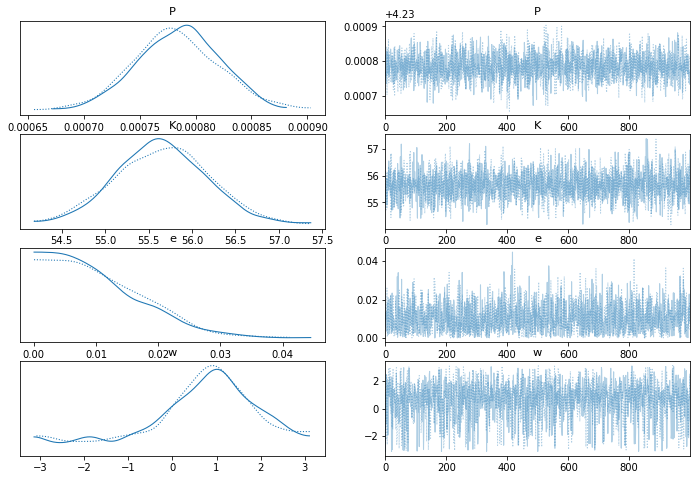

In [47]:
_ = az.plot_trace(trace, var_names = ['P', 'K', 'e','w'])

In [48]:
rvmodel = trace.posterior['rvmodel'].values

porb = np.median(trace.posterior['P'].values)
periods_ = np.percentile(trace.posterior['P'].values, [16, 50, 84])
p_q = np.diff(periods_)

q16, q50, q84 = np.percentile(rvmodel, [16, 50, 84], axis = (0, 1)) # Quantiles

In [49]:
residuals = y - map_params['rvmodel']

In [50]:
phase_ = lambda t, period: np.remainder(t, period)/period

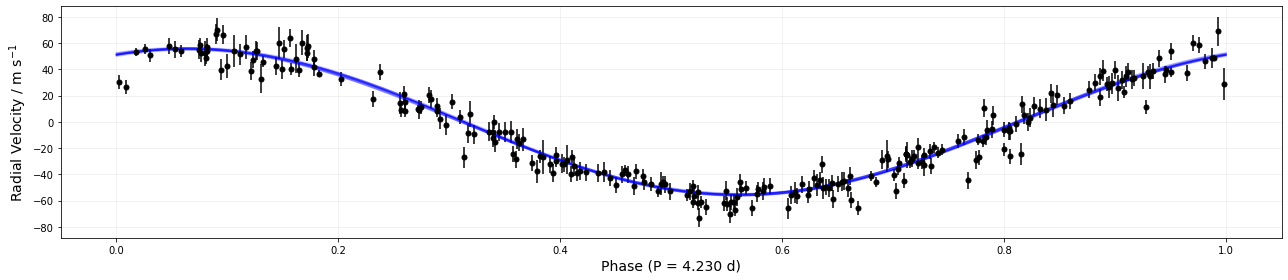

In [51]:
fig, ax1 = plt.subplots(figsize = (12*1.5, 4), nrows = 1, ncols = 1)

bkg = trace.posterior['bkg'].values
rvphase = trace.posterior['rvphase'].values
rvmodel = trace.posterior['rvmodel'].values

ax1.set_ylabel(r'Radial Velocity / m s$^{-1}$', fontsize = 14)
ax1.set_xlabel(r'Phase (P = %.3f d)'%(period), fontsize = 14)
ax1.grid(alpha = 0.2)
ax1.errorbar(phase_(x, period), y, yerr = yerr, fmt = 'ok', ecolor = 'black')

for ind in np.random.randint(np.prod(bkg.shape[:2]), size = 25):
    i = np.unravel_index(ind, bkg.shape[:2])
    ax1.plot(phase, rvphase[i], color = 'blue', lw = 1.0, alpha = 0.2)

plt.tight_layout()
plt.savefig('51Pegb_RV_phased.pdf')

In [52]:
P = (np.repeat(np.asarray(trace.posterior['P']).flatten(), 100) * u.d)
K = (np.repeat(np.asarray(trace.posterior['K']).flatten(), 100) *(u.m/u.s))
e = (np.repeat(np.asarray(trace.posterior['e']).flatten(), 100))
w = (np.repeat(np.asarray(trace.posterior['w']).flatten(), 100))
M = 1.11 * u.Msun

In [53]:
msini = radvel.utils.Msini(K, P, M, e, Msini_units = 'jupiter')
msini_ = (msini*u.Mjup).to(u.Msun)
print(np.median(msini))

0.47474047330773095


In [54]:
a = radvel.utils.semi_major_axis(P, msini_ + M) * u.AU
print(np.median(a.value))

0.05301291233758382


In [55]:
ch = np.vstack((P.value, K.value, np.sqrt(e)*np.sin(w), np.sqrt(e)*np.cos(w), msini, a.value))

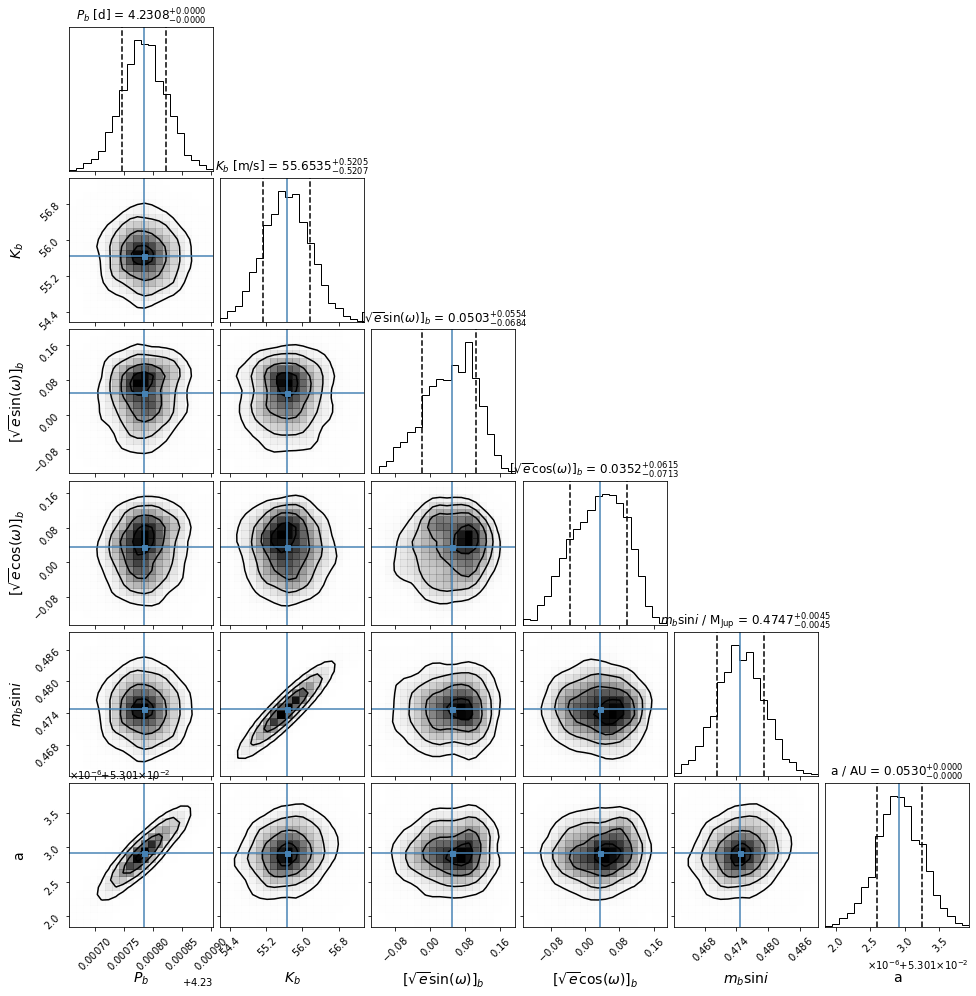

In [56]:
_ = corner.corner(ch.T,
                  smooth = True,
                  bins = 20, 
                  quantiles = [0.16, 0.84], 
                  show_titles = True,
                  title_fmt = '.4f',
                  label_kwargs = dict(fontsize = 14),
                  labels = ['$P_{b}$', 
                            '$K_{b}$', 
                            r'$[\sqrt{e}\sin(\omega)]_{b}$', 
                            r'$[\sqrt{e}\cos(\omega)]_{b}$', 
                            r'$m_{b}\sin{i}$', 
                            r'a'],
                  titles = ['$P_{b}$ [d]', 
                            '$K_{b}$ [m/s]', 
                            r'$[\sqrt{e}\sin(\omega)]_{b}$', 
                            r'$[\sqrt{e}\cos(\omega)]_{b}$', 
                            r'$m_{b}\sin{i}$ / M$_{\rm Jup}$', 
                            r'a / AU'], 
                  title_kwargs = {'fontsize':12},
                  truths = [np.median(ch[0]), 
                            np.median(ch[1]), 
                            np.median(ch[2]), 
                            np.median(ch[3]), 
                            np.median(ch[4]), 
                            np.median(ch[5])], 
                  use_math_text = True, 
                  plot_datapoints = False,
                  verbose = False)